In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import tensorflow as tf
import os
import random
from PIL import Image
import requests
from io import BytesIO

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/My Drive/Plastic_Recyclability_Dataset'

batches = []
for batch in os.listdir(path):
    if batch[0:5] == "batch":
        batches.append(np.fromfile(path + "/" + batch, dtype=np.uint8, count=-1))
inputs = np.concatenate(batches)

labels = np.fromfile(path + "/labels.bin", dtype=np.uint8, count=-1)

inputs = inputs.reshape((-1,128,128,3))
print(inputs.shape)
print(labels.shape)

(8424, 128, 128, 3)
(8424,)


In [0]:
weights_path = path + '/checkpoints/res_cp.cpkt'

In [0]:
def create_convblock(input_tensor, filters, kernel_size=(2,2), strides=(1,1), name="", padding="valid", activation=True):
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, data_format="channels_last",
                             use_bias=False, name="conv"+name, kernel_initializer="he_normal", 
                             kernel_regularizer=tf.keras.regularizers.l2(1e-2))(input_tensor)
  x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-4, trainable=True, name="batch_norm"+name)(x)
  if(activation):
    x = tf.keras.layers.ReLU(name="relu"+name)(x)
  return x

In [0]:
def create_resblock(input_tensor, filters, kernel_size=(2,2), strides=(1,1), padding="same", block_num=0):
  s = str(block_num)
  sa = s + "a"
  sb = s + "b"
  
  x = create_convblock(input_tensor, filters, kernel_size=kernel_size, strides=strides, padding=padding, name=s+"a")
  
  x = create_convblock(x, filters, kernel_size=kernel_size, strides=strides, padding=padding, name=s+"b", activation=False)

  x = tf.keras.layers.add([input_tensor, x], name="add"+s)
  x = tf.keras.layers.ReLU(name="relu"+s+"b")(x)
  x = tf.keras.layers.SpatialDropout2D(rate=0.3)(x)
  return x

In [0]:
def create_downsample_resblock(input_tensor, filters, kernel_size=(3,3), padding="same", block_num=0):
  s = str(block_num)
  
  x = create_convblock(input_tensor, filters, kernel_size=kernel_size, strides=(2,2), padding=padding, name=s+"a")
  
  x = create_convblock(x, filters, kernel_size=kernel_size, strides=(1,1), padding=padding, name=s+"b", activation=False)
  
  #1x1 convolutions with stride 2 on input tensor
  input_tensor = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding=padding, name="conv_1x1"+s)(input_tensor)
  
  x = tf.keras.layers.add([input_tensor, x], name="add"+s)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.SpatialDropout2D(rate=0.3)(x)
  return x

In [0]:
filters=32

input_tensor = tf.keras.layers.Input(shape=(128,128,3))
x = input_tensor
x = create_convblock(input_tensor, filters, kernel_size=(3,3), strides=(2,2), name="0") 
x = create_resblock(x, filters, kernel_size=(3,3), block_num=1)

filters=64
x = create_downsample_resblock(x, filters, kernel_size=(3,3), block_num=4)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=5)

filters=128
x = create_downsample_resblock(x, filters, kernel_size=(3,3), block_num=7)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=8)

x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = tf.keras.layers.Dense(units=2, kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                         bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
output = tf.keras.layers.Softmax()(x)

model = tf.keras.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])

In [14]:
model.load_weights(weights_path)

In [15]:
p_test = model.predict(inputs)
p_test = np.argmax(p_test, axis=1)

print("test acc:", metrics.accuracy_score(labels, p_test))

test acc: 0.9246201329534662


In [0]:
def predict(input):
  p = model.predict(input)
  if p[0][0]>p[0][1]:
    print("predicting that the object is RECYCLABLE with confidence ", p[0][0])
  else:
    print("predicting that the object is MAYBE RECYLABLE with confidence ", p[0][1])

In [0]:
def predict_random_input():
  num = random.randint(0, len(inputs))
  plt.imshow(inputs[num])
  predict(np.expand_dims(inputs[num], axis=0))

In [0]:
IMAGE_SIZE = 128
def predict_image_url(url):
  r = requests.get(url)
  img = Image.open(BytesIO(r.content))
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  plt.imshow(img)
  pixels = np.array(img.getdata()).reshape((1,IMAGE_SIZE,IMAGE_SIZE,3))
  predict(pixels)

## Demo random image from dataset

predicting that the object is RECYCLABLE with confidence  0.99291503


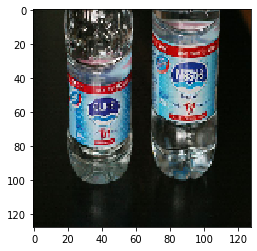

In [97]:
predict_random_input()

## Demo images with given URLS

predicting that the object is MAYBE RECYLABLE with confidence  0.9947973


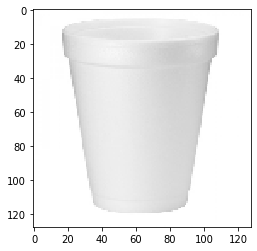

In [98]:
predict_image_url("https://ds5cvxtqu2rt0.cloudfront.net/media/catalog/product/cache/1/image/700x700/17f82f742ffe127f42dca9de82fb58b1/2/1/21437fl_lg.jpg")

predicting that the object is RECYCLABLE with confidence  0.9603478


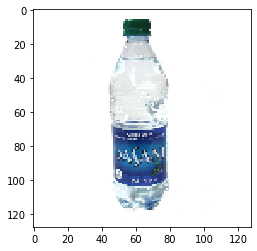

In [99]:
predict_image_url("https://cdn11.bigcommerce.com/s-9w4zwzbhcc/images/stencil/2000x2000/products/233/2872/Dasani_water_bottle__63919.1548271788.JPG?c=2")

predicting that the object is RECYCLABLE with confidence  0.66497177


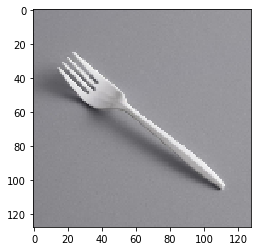

In [100]:
predict_image_url("https://cdnimg.webstaurantstore.com/images/products/large/66832/1863558.jpg")

predicting that the object is RECYCLABLE with confidence  0.9519261


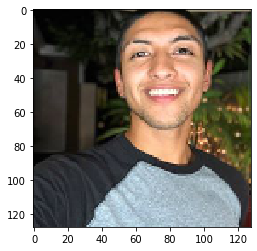

In [101]:
predict_image_url("https://scontent-lax3-1.xx.fbcdn.net/v/t1.0-1/c0.39.240.240a/p240x240/53086074_1637225263047727_5368641023293521920_o.jpg?_nc_cat=102&_nc_oc=AQkg0xu1G_ViLUpVleVFe21SgfZoB7QwrAfi1ZVVtUqhuYlfSHNLs2RHxFNsm23edkY&_nc_ht=scontent-lax3-1.xx&oh=74cdce12c7c345fc489ae68f543218bd&oe=5EBF584B")

predicting that the object is MAYBE RECYLABLE with confidence  0.9719847


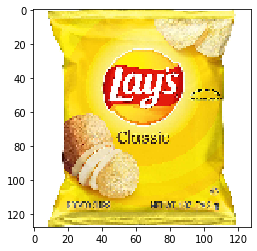

In [102]:
predict_image_url("https://images-na.ssl-images-amazon.com/images/I/81vJyb43URL._SL1500_.jpg")

predicting that the object is MAYBE RECYLABLE with confidence  0.95768344


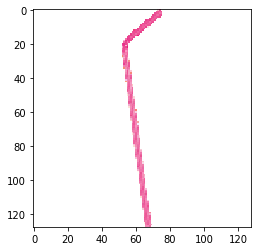

In [103]:
predict_image_url("https://i5.walmartimages.com/asr/f0bd2129-e5a2-4fa1-9d8d-e83258647b39_1.ee6dbc7768ecef82cc3eaa9a5e423b6f.jpeg")

predicting that the object is RECYCLABLE with confidence  0.91411734


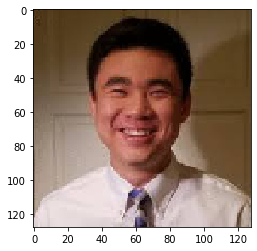

In [104]:
predict_image_url("https://scontent-lax3-1.xx.fbcdn.net/v/t1.0-1/60902898_449895725771557_2323022702304034816_n.jpg?_nc_cat=103&_nc_oc=AQkDtj2_J9ruhHPDEdy4h8vmANM2bvfxDAxNxFM0VmPgixXH3565euqB6Llh0FRbkNk&_nc_ht=scontent-lax3-1.xx&oh=9d338d0091df3c5430e639f146042c7a&oe=5EFE2209")

predicting that the object is RECYCLABLE with confidence  0.9810175


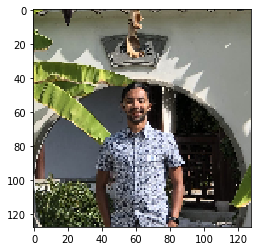

In [105]:
predict_image_url("https://zotbins.github.io/img/headshots/Primal_Pappachan.jpg")